In [1]:
EXP_NAME = "preprocessing"

In [2]:
# Cell 1 - Setup, imports, scelta esperimento

import os
import sys

# Add local_lib to path BEFORE importing torch and other packages
BASE_DIR = os.getcwd()
LOCAL_LIB = os.path.join(BASE_DIR, 'local_lib')
if os.path.exists(LOCAL_LIB) and LOCAL_LIB not in sys.path:
    sys.path.insert(0, LOCAL_LIB)

import torch
from sklearn.metrics import classification_report

try:
    import google.colab  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive")
    PROJECT_ROOT = "/content/drive/MyDrive/[2025-2026] AN2DL/challenge2"
else:
    PROJECT_ROOT = os.getcwd()

os.chdir(PROJECT_ROOT)
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

print("Project root:", PROJECT_ROOT)
print("Working dir:", os.getcwd())

# Force reload of config module to get latest changes
import importlib
if 'includes.config' in sys.modules:
    importlib.reload(sys.modules['includes.config'])

from includes.config import TrainingConfig, GRID_SEARCH_SPACES
from includes.data_utils import (
    load_labels_and_split,
    load_full_labels,
    get_transforms,
    create_dataloaders,
)

from includes.model_utils import (
    build_model,
    create_criterion_optimizer_scheduler,
    train_model,
    evaluate,
)
from includes.inference_utils import create_test_loader, run_inference_and_save

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Verifica che la chiave esista
print("\nAvailable experiments in GRID_SEARCH_SPACES:")
for exp in GRID_SEARCH_SPACES.keys():
    print(f"  - {exp}")

# base cfg con default (paths, val_size, ecc.)
cfg = TrainingConfig(exp_name=EXP_NAME)
cfg.project_root = PROJECT_ROOT
cfg.out_dir = "out"

# griglia associata a questo esperimento
if EXP_NAME not in GRID_SEARCH_SPACES:
    raise KeyError(f"Experiment '{EXP_NAME}' not found in GRID_SEARCH_SPACES. Available: {list(GRID_SEARCH_SPACES.keys())}")

param_grid = GRID_SEARCH_SPACES[EXP_NAME]
param_grid

Project root: c:\Users\danie\ANN
Working dir: c:\Users\danie\ANN
Using device: cuda

Available experiments in GRID_SEARCH_SPACES:
  - preprocessing
  - test
  - resnet50_img384
  - resnet50_img384_preprocessing
  - resnet50_img384_preprocessing_25ep
  - resnet50_img384_preprocessing_250ep
  - resnet50_img384_pp_optimized


{'train_img_dir': ['pp_train_data'],
 'test_img_dir': ['pp_test_data'],
 'labels_csv': ['pp_train_labels.csv'],
 'pp_remove_shrek': [True],
 'pp_fix_stained': [True],
 'pp_split_doubles': [True],
 'pp_remove_black_rect': [True],
 'pp_padding_square': [False],
 'pp_crop_to_mask': [False],
 'pp_resize_and_normalize': [True],
 'pp_augmentation_enabled': [True],
 'pp_crop_padding': [10],
 'pp_target_size': [384],
 'pp_apply_clahe': [False],
 'pp_clahe_clip_limit': [2.0],
 'pp_clahe_tile_grid': [(16, 16)],
 'pp_num_aug_copies': [1],
 'pp_strong_rotation_degrees': [15],
 'pp_strong_zoom_min': [0.8],
 'pp_strong_zoom_max': [1.0],
 'pp_strong_brightness': [0.2],
 'pp_strong_contrast': [0.2],
 'pp_strong_saturation': [0.2],
 'pp_strong_hue': [0.05],
 'pp_strong_random_erasing_p': [0.1],
 'execute': False}

In [3]:
# Cell X - Preprocessing configuration and optional run

import os
import sys
import json
import subprocess

from includes.config import PREPROCESSING_KEYS

# Flag "preprocessing": if False, do not run preprocessing and do not check pp_ params
RUN_PREPROCESSING = True  # set to False if you already have pp_* data and want to skip

def build_preprocessing_config(param_grid: dict) -> dict:
    """
    Extract offline preprocessing config from param_grid.

    Logical constraint: for every key in PREPROCESSING_KEYS
    that appears in the param_grid, there MUST be exactly one value
    (no grid search on preprocessing). If not, raise an error.
    """
    preproc_cfg = {}
    for key in PREPROCESSING_KEYS:
        if key in param_grid:
            values = param_grid[key]
            if not isinstance(values, (list, tuple)) or len(values) != 1:
                raise ValueError(
                    f"Preprocessing parameter '{key}' must have exactly ONE value in the grid. "
                    f"Current values: {values}"
                )
            preproc_cfg[key] = values[0]
    return preproc_cfg


if RUN_PREPROCESSING:
    # 1) Build preprocessing config from grid search config
    preproc_cfg = build_preprocessing_config(param_grid)

    print("========== PREPROCESSING CONFIG ==========")
    for k, v in preproc_cfg.items():
        print(f"{k}: {v}")
    print("==========================================")

    # 2) Call preprocessing/preprocessing.py passing the config as JSON
    preproc_script = os.path.join(PROJECT_ROOT, "preprocessing", "preprocessing.py")

    cmd = [
        sys.executable,               # current Python interpreter
        preproc_script,
        json.dumps(preproc_cfg),      # first argument: JSON with pp_* config
    ]

    print("\n>>> Running offline preprocessing...")
    completed = subprocess.run(cmd, check=True)
    print(">>> Preprocessing finished with returncode:", completed.returncode)
else:
    print("RUN_PREPROCESSING=False: skipping preprocessing and pp_ parameter checks.")


if param_grid.get("execute", True):
    print("\n>>> Proceeding to training phase...")
else:
    print("\n>>> 'execute' flag is False: skipping training phase.")
    sys.exit(0)

# 3) Build a new param_grid for TRAINING ONLY (without preprocessing keys)
train_param_grid = {
    k: v for k, v in param_grid.items() if k not in PREPROCESSING_KEYS
}

print("\nTraining param_grid keys:", list(train_param_grid.keys()))


========== PREPROCESSING CONFIG ==========
pp_remove_shrek: True
pp_fix_stained: True
pp_split_doubles: True
pp_remove_black_rect: True
pp_padding_square: False
pp_crop_to_mask: False
pp_resize_and_normalize: True
pp_augmentation_enabled: True
pp_crop_padding: 10
pp_target_size: 384
pp_apply_clahe: False
pp_clahe_clip_limit: 2.0
pp_clahe_tile_grid: (16, 16)
pp_num_aug_copies: 1
pp_strong_rotation_degrees: 15
pp_strong_zoom_min: 0.8
pp_strong_zoom_max: 1.0
pp_strong_brightness: 0.2
pp_strong_contrast: 0.2
pp_strong_saturation: 0.2
pp_strong_hue: 0.05
pp_strong_random_erasing_p: 0.1

>>> Running offline preprocessing...
>>> Preprocessing finished with returncode: 0

>>> 'execute' flag is False: skipping training phase.


SystemExit: 0

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# Cell 2 - Grid search with optional StratifiedKFold (TRAINING ONLY)

import itertools
import copy
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import StratifiedKFold

base_cfg = cfg  # base config for this experiment (already has exp_name, project_root, etc.)

# IMPORTANT: use ONLY training grid (without pp_* keys)
keys = list(train_param_grid.keys())
values_list = [train_param_grid[k] for k in keys]
combos = list(itertools.product(*values_list))
n_combos = len(combos)

print("==============================================================")
print(f"GRID SEARCH for experiment '{EXP_NAME}' with {n_combos} combinations")
print("Param keys (training only):", keys)
print("==============================================================")

results = []
best_val_f1 = -1.0
best_cfg = None
best_state_dict = None
best_idx_to_label = None
best_val_t = None

for i, values in enumerate(combos, start=1):
    params = dict(zip(keys, values))

    print("\n--------------------------------------------------------------")
    print(f"[Grid {i}/{n_combos}] params = {params}")

    # Validation strategy from params (fallback to holdout)
    cv_type = params.get("cv_type", "holdout")
    n_splits = int(params.get("n_splits", 5))

    # 1) Copy base cfg and attach all params as attributes
    cfg_i = copy.deepcopy(base_cfg)
    for k, v in params.items():
        setattr(cfg_i, k, v)

    # 2) Common: full labels + transforms
    labels_df, unique_labels, label_to_idx, idx_to_label_i = load_full_labels(cfg_i)
    train_t_i, val_t_i = get_transforms(cfg_i)
    num_classes = len(unique_labels)

    fold_f1s = []
    best_state_i = None

    if cv_type == "kfold":
        # ----- Stratified K-Fold -----
        print(f"  >> Using StratifiedKFold with {n_splits} folds")

        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=cfg_i.random_seed,
        )

        best_fold_f1 = -1.0

        for fold, (train_idx, val_idx) in enumerate(
            skf.split(labels_df, labels_df["label_idx"]), start=1
        ):
            print(f"    [Fold {fold}/{n_splits}]")

            train_df = labels_df.iloc[train_idx].reset_index(drop=True)
            val_df = labels_df.iloc[val_idx].reset_index(drop=True)

            train_loader_i, val_loader_i = create_dataloaders(
                cfg_i, train_df, val_df, train_t_i, val_t_i
            )

            model_i = build_model(cfg_i, num_classes=num_classes, device=device)
            criterion_i, optimizer_i, scheduler_i = create_criterion_optimizer_scheduler(
                cfg_i, model_i, train_df, device
            )

            best_state_fold, history_fold = train_model(
                cfg_i,
                model_i,
                train_loader_i,
                val_loader_i,
                criterion_i,
                optimizer_i,
                scheduler_i,
                device,
            )

            val_f1_list = history_fold.get("val_f1", history_fold.get("val_acc", []))
            fold_best_f1 = max(val_f1_list) if val_f1_list else 0.0
            fold_f1s.append(fold_best_f1)
            print(f"    >> Fold best F1: {fold_best_f1:.4f}")

            if fold_best_f1 > best_fold_f1:
                best_fold_f1 = fold_best_f1
                best_state_i = copy.deepcopy(best_state_fold)

            del model_i
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        run_best_f1 = float(np.mean(fold_f1s))
        print(f"  >> Mean F1 over {n_splits} folds: {run_best_f1:.4f}")

    else:
        # ----- Standard hold-out validation (current behaviour) -----
        train_df, val_df, unique_labels, label_to_idx, idx_to_label_i = load_labels_and_split(
            cfg_i
        )
        train_t_i, val_t_i = get_transforms(cfg_i)
        train_loader_i, val_loader_i = create_dataloaders(
            cfg_i, train_df, val_df, train_t_i, val_t_i
        )

        model_i = build_model(cfg_i, num_classes=num_classes, device=device)
        criterion_i, optimizer_i, scheduler_i = create_criterion_optimizer_scheduler(
            cfg_i, model_i, train_df, device
        )

        best_state_i, history_i = train_model(
            cfg_i,
            model_i,
            train_loader_i,
            val_loader_i,
            criterion_i,
            optimizer_i,
            scheduler_i,
            device,
        )

        val_f1_list = history_i.get("val_f1", history_i.get("val_acc", []))
        run_best_f1 = max(val_f1_list) if val_f1_list else 0.0
        print(f"Best val F1 for this run: {run_best_f1:.4f}")

        del model_i
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # 3) Save result row
    row = {"run": i, "best_val_f1": run_best_f1}
    for k in keys:
        row[k] = params[k]
    results.append(row)

    # 4) Update global best
    if run_best_f1 > best_val_f1:
        best_val_f1 = run_best_f1
        best_cfg = copy.deepcopy(cfg_i)
        best_state_dict = copy.deepcopy(best_state_i)
        best_idx_to_label = idx_to_label_i
        best_val_t = val_t_i

# ---------- grid search summary ----------
results_df = pd.DataFrame(results).sort_values("best_val_f1", ascending=False)
print("\n================ GRID SEARCH SUMMARY ================")
print(results_df)

print("\nBest config (from grid):")
print(best_cfg.__dict__)
print("Best val F1:", best_val_f1)

# ---------- objects for the rest of the notebook ----------
cfg = best_cfg
idx_to_label = best_idx_to_label
val_t = best_val_t

num_classes = len(idx_to_label)
model = build_model(cfg, num_classes=num_classes, device=device)
model.load_state_dict(best_state_dict)


GRID SEARCH for experiment 'resnet50_img384_pp_optimized' with 1 combinations
Param keys: ['train_img_dir', 'test_img_dir', 'labels_csv', 'backbone', 'img_size', 'batch_size', 'num_workers', 'lr', 'weight_decay', 'epochs', 'use_scheduler', 'use_masks', 'mask_mode', 'label_smoothing', 'cv_type', 'n_splits']

--------------------------------------------------------------
[Grid 1/1] params = {'train_img_dir': 'pp_train_data', 'test_img_dir': 'pp_test_data', 'labels_csv': 'pp_train_labels.csv', 'backbone': 'resnet50', 'img_size': 384, 'batch_size': 16, 'num_workers': 6, 'lr': 0.0002, 'weight_decay': 0.0001, 'epochs': 100, 'use_scheduler': True, 'use_masks': True, 'mask_mode': 'multiply', 'label_smoothing': 0.1, 'cv_type': 'holdout', 'n_splits': 5}
Starting training - experiment: resnet50_img384_pp_optimized
Backbone: resnet50  |  img_size: 384  |  epochs: 100

--------------------------------------------------------------
[Epoch 1/100]
    [Batch 158/158] loss=1.4176  f1=0.2787
  Train - l

<All keys matched successfully>

=== CLASS DISTRIBUTION ===

Training set:
label
HER2(+)            636
Luminal A          696
Luminal B          880
Triple negative    308
Name: count, dtype: int64
Total train samples: 2520

Validation set:
label
HER2(+)            159
Luminal A          174
Luminal B          220
Triple negative     77
Name: count, dtype: int64
Total val samples: 630

=== TRAINING CONFIG ===
Experiment name: resnet50_img384_pp_optimized
Backbone     : resnet50
Image size   : 384
Learning rate: 0.0002
Epochs       : 100
Batch size   : 16
Use masks    : True
Mask mode    : multiply
Augmentation : strong

=== CLASS WEIGHTS ===
HER2(+): 0.8508 (count: 636)
Luminal A: 0.7775 (count: 696)
Luminal B: 0.6149 (count: 880)
Triple negative: 1.7568 (count: 308)

=== CONFUSION MATRIX (validation, best model) ===


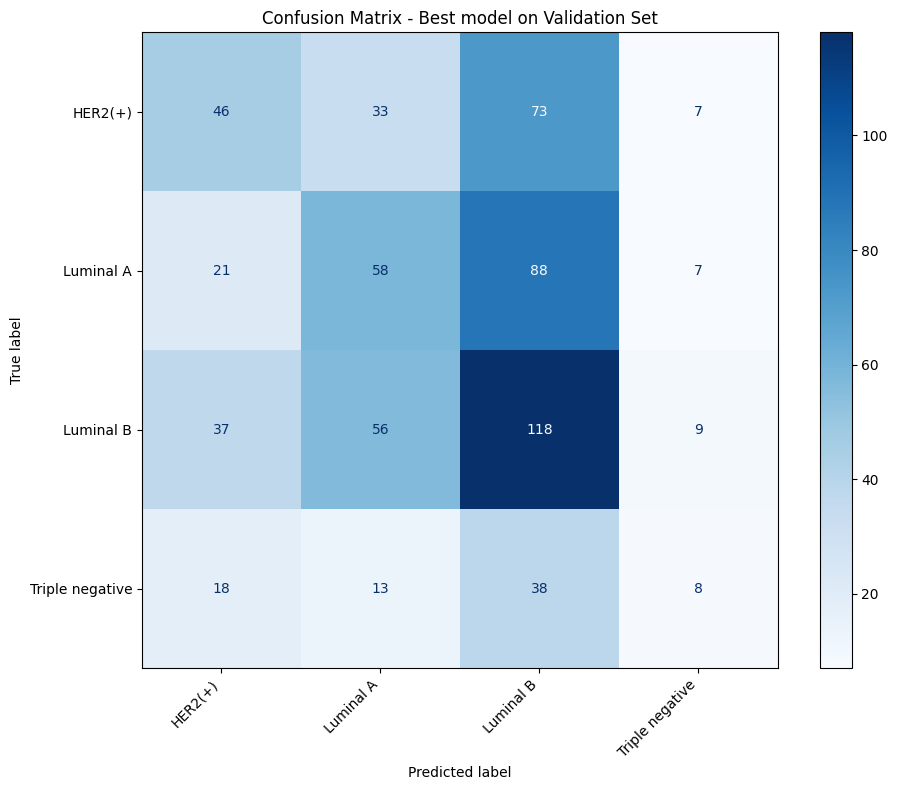

In [ ]:
# Cell 3 - Diagnostics & Confusion Matrix for best config

import pandas as pd
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ricrea train/val split e dataloader per la best cfg
train_df, val_df, unique_labels, label_to_idx, idx_to_label = load_labels_and_split(cfg)
train_t_diag, val_t_diag = get_transforms(cfg)
train_loader_diag, val_loader_diag = create_dataloaders(
    cfg, train_df, val_df, train_t_diag, val_t_diag
)

# ---------- CLASS DISTRIBUTION ----------
print("=== CLASS DISTRIBUTION ===")
print("\nTraining set:")
print(train_df["label"].value_counts().sort_index())
print(f"Total train samples: {len(train_df)}")

print("\nValidation set:")
print(val_df["label"].value_counts().sort_index())
print(f"Total val samples: {len(val_df)}")

# ---------- TRAINING CONFIG ----------
print("\n=== TRAINING CONFIG ===")
print(f"Experiment name: {cfg.exp_name}")
print(f"Backbone     : {cfg.backbone}")
print(f"Image size   : {cfg.img_size}")
print(f"Learning rate: {cfg.lr}")
print(f"Epochs       : {cfg.epochs}")
print(f"Batch size   : {cfg.batch_size}")
print(f"Use masks    : {cfg.use_masks}")
print(f"Mask mode    : {cfg.mask_mode if cfg.use_masks else 'N/A'}")
print(f"Augmentation : {getattr(cfg, 'augmentation', 'strong')}")

# ---------- CLASS WEIGHTS ----------
class_counts = train_df["label_idx"].value_counts().sort_index().values.astype(float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)

print("\n=== CLASS WEIGHTS ===")
for i, (label, weight) in enumerate(zip(unique_labels, class_weights)):
    print(f"{label}: {weight:.4f} (count: {int(class_counts[i])})")

# ---------- Confusion matrix on validation set ----------
print("\n=== CONFUSION MATRIX (validation, best model) ===")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader_diag:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Best model on Validation Set")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# tieni idx_to_label aggiornato per l'inference
idx_to_label = idx_to_label
val_t = val_t_diag


In [ ]:
# Cell 4 - Inference and submission (best model from grid search)

test_loader, test_files = create_test_loader(cfg, val_t)

submission_name = f"submission_{cfg.exp_name}.csv"

run_inference_and_save(
    cfg,
    model,
    test_loader,
    idx_to_label,
    device,
    output_csv=submission_name,
)


Number of test images: 477
First 5 test files: ['img_0000.png', 'img_0001.png', 'img_0002.png', 'img_0003.png', 'img_0004.png']
[run_inference_and_save] exp_name=resnet50_img384_pp_optimized | filename='submission_resnet50_img384_pp_optimized.csv'
Saved submission to: c:\Users\danie\ANN\out\submission_resnet50_img384_pp_optimized.csv


'c:\\Users\\danie\\ANN\\out\\submission_resnet50_img384_pp_optimized.csv'